# Substing Search lab for High Performance Computing course
- Python 3.7
- CUDA 11.4
- NVIDIA GeForce GTX 1050 Ti
- Intel Core i5
- Windows 10

## Implementation

В работе для применения технологиии CUDA была исползована библиотека numba. Размерность блоков фиксированная и была установлена значением 16х16.

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numba import cuda
from tabulate import tabulate

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16
# Number of iteration to be done to compute the average elapsed time
ITER_COUNT = 1
# Precision
EPS = 10e-5

Была реализована следующая функция, которая выполняет массовый поиск подстрок на GPU с помощью CUDA.



In [ ]:
@cuda.jit
def gpu_mass_search(N, H, R):
    """
    Performs mass search of substrings N in the input buffer H on GPU using CUDA
    and saves the result to the working matrix R.
    """
    # Thread indices
    x, y = cuda.grid(2)
    # Iterate over all symbols in all substrings N in parallel
    for k in range(N.shape[1]):
        # If a symbol in a substring matches a symbol in the input buffer
        if N[y, k] == H[x]:
            # Decrement the corresponding element of the working matrix
            R[y, x - k] -= 1
    cuda.syncthreads()

Была релизована аналогичная функция, работающая на CPU.



In [ ]:
def cpu_mass_search(N, H, R):
    """
    Performs mass search of substrings N in the input buffer H on CPU using Numpy
    and saves the result to the working matrix R.
    """
    # Iterate over all columns of R, i.e. all symbols of the input buffer
    for x in range(R.shape[1]):
        # Iterate over all rows of R, i.e. all substrings N
        for y in range(R.shape[0]):
            # Iterate over all symbols in the substring
            for k in range(N.shape[1]):
                # If a symbol in a substring matches a symbol in the input buffer
                if N[y, k] == H[x]:
                    # Decrement the corresponding element of the working matrix
                    R[y, x - k] -= 1
    return R

Был написан основной алгоритм-оболочка для этих двух функций, который считает их время работы, сравнивает и возварщает результат.



In [ ]:
def main_algorithm(N: np.ndarray, H: np.ndarray, R: np.ndarray, sfap=False, stf=False, filename=""):
    """
    Executes the GPU and CPU functions for the same data one at a time and returns their elapsed time,
    the result and whether those functions produced the same result
    """
    # Save input data if specified
    if stf and filename != "":
        with open(filename, 'wb') as file:
            file.write(H.tobytes())
            for n in N:
                file.write(n.tobytes())

    # Measure the GPU function elapsed time
    start = time.time()
    # Copy the the input data to the device memory
    d_N = cuda.to_device(N)
    d_H = cuda.to_device(H)
    d_R = cuda.to_device(R)
    # Initialize the grid size and block size for the CUDA kernel
    grid_size = (int(N.shape[0] / TPB), int(H.shape[0] / TPB))
    block_size = (TPB, TPB)
    # Perform the mass search on GPU
    gpu_mass_search[grid_size, block_size](d_N, d_H, d_R)
    # Copy the working matrix to host
    gpu_R = d_R.copy_to_host()
    gpu_time = time.time() - start

    # Measure the CPU function elapsed time
    start = time.time()
    cpu_R = cpu_mass_search(N, H, R.copy())
    cpu_time = time.time() - start

    # Check if the GPU and CPU working matrices match
    results_match = np.array_equal(cpu_R, gpu_R)

    # Form the result representation
    result = np.array(np.where(cpu_R == 0))
    if sfap:
        # Save the substrings indexes and positions
        result = result.transpose()
    else:
        # Save only the substring indexes
        result = result[0]

    return gpu_time, cpu_time, results_match, result

Была написана функция для тестирования основного алгоритма для проверки корректности работы реализованных функций.

In [ ]:
def test_main_algorithm():
    """
    Tests the main algorithm for one time and prints the input data and the result
    to check if the implemented functions work correctly
    """
    n = TPB  # number of substrings
    h = n  # input buffer length

    # Generate the set of substrings
    N = np.arange(n * 2, dtype=np.uint8).reshape((n, 2))
    # Generate the input buffer
    H = np.arange(TPB, dtype=np.uint8)
    # Generate the working matrix with zeros
    R = np.zeros((h, h), dtype=np.uint8)
    # Fill the working matrix with the substrings lengths
    for i in range(R.shape[0]):
        R[i, :] = N[i].size
    # Print input data
    print("Input buffer: ")
    print(H)
    print("Substrings: ")
    for i in range(N.shape[0]):
        print(N[i])

    # Execute the main algorithm and print the result
    _, _, match, result = main_algorithm(N, H, R, True, False)
    print("Result (substring index, substring position):")
    print(result)
    print(match)

Была написана вторая функция для тестирования основного алгоритма для рассчета среднего времени выполения массового поиска на CPU и GPU, рассчета ускорения и вывода таблицы результатов и графиков.

In [ ]:
def test_main_algorithm_time():
    """
    Tests the main algorithm to measure the average elapsed time of the GPU and CPU functions
    over ITER_COUNT iterations for different input data sizes.
    """
    rows = []  # rows for the result table
    nn = []  # numbers of substrings on each iteration
    gpu_times = []  # GPU elapsed time measurements
    cpu_times = []  # CPU elapsed time measurements
    accelerations = []  # CPU to GPU time ratios
    # Iterate over different numbers of blocks per grid
    for bpg in range(10, 100, 10):
        n = TPB * bpg  # number of substrings
        h = n  # input buffer length

        gpu_time_sum = 0
        cpu_time_sum = 0
        results_match = True
        # Execute the main algorithm ITER_COUNT times one at a time to measure average elapsed time
        for _ in range(ITER_COUNT):
            # Generate the set of substrings
            N = np.random.randint(255, size=(n, 2), dtype=np.uint8)
            # Generate the input buffer
            H = np.random.randint(255, size=h, dtype=np.uint8)
            # Generate the working matrix
            R = np.zeros((h, h), dtype=np.uint8)

            # Fill the working matrix with the substrings lengths
            for i in range(R.shape[0]):
                R[i, :] = N[i].size
            # Get result from the main algorithm
            gpu_time, cpu_time, results_match, _ = main_algorithm(N, H, R, True, False)
            gpu_time_sum += gpu_time
            cpu_time_sum += cpu_time

        # Process and save the data accumulated by the previous for-loop
        gpu_time_avg = gpu_time_sum / ITER_COUNT
        cpu_time_avg = cpu_time_sum / ITER_COUNT
        acc = cpu_time_avg / (gpu_time_avg if gpu_time_avg > EPS else EPS)
        nn.append(n)
        gpu_times.append(gpu_time_avg)
        cpu_times.append(cpu_time_avg)
        accelerations.append(acc)
        row = [n, h, cpu_time_avg, gpu_time_avg, acc, results_match]
        rows.append(row)
    # Print the table with the main algorithm results
    print(tabulate(rows, headers=['N size', 'H size', 'CPU time, ms', 'GPU time, ms', 'Acceleration', 'Results match']))
    print()

    plt.figure(figsize=(18,4))

    plt.subplot(1, 3, 1)
    plt.title("CPU time")
    plt.plot(nn, cpu_times)
    plt.xlabel("N and H size")
    plt.ylabel("Time, ms")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("GPU time")
    plt.plot(nn, gpu_times)
    plt.xlabel("N and H size")
    plt.ylabel("Time, ms")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("Acceleration")
    plt.plot(nn, accelerations)
    plt.xlabel("N and H size")
    plt.ylabel("CPU to GPU time ratio")
    plt.grid()

    plt.show()

## Results




### Test #1
Была запущена функция test_main_algorithm и получены слудующие результаты. Из результатов можно сдлеать вывод, что программа работает корректно.

In [ ]:
test_main_algorithm()

Input buffer: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Substrings: 
[0 1]
[2 3]
[4 5]
[6 7]
[8 9]
[10 11]
[12 13]
[14 15]
[16 17]
[18 19]
[20 21]
[22 23]
[24 25]
[26 27]
[28 29]
[30 31]
Result (substring index, substring position):
[[ 0  0]
 [ 1  2]
 [ 2  4]
 [ 3  6]
 [ 4  8]
 [ 5 10]
 [ 6 12]
 [ 7 14]]
True


D:\Projects\hpc-labs\venv\lib\site-packages\numba\cuda\compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (12) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


### Test #2
Была запущена функция test_main_algorithm_time и получены слудующие результаты. Из результатов, можно сделать вывод, что реализованная функция массового поиска подстрок на GPU с помощью CUDA дает значительный выигрыш по сравнению с аналогичной функцией на CPU.



  N size    H size    CPU time, ms    GPU time, ms    Acceleration  Results match
--------  --------  --------------  --------------  --------------  ---------------
     160       160       0.0160234      0.00300026         5.34067  True
     320       320       0.0670166      0.00098443        68.0765   True
     480       480       0.156025       0.00097537       159.965    True
     640       640       0.282          0.00199914       141.061    True
     800       800       0.422998       0.00199938       211.565    True
     960       960       0.600972       0.00199533       301.19     True
    1120      1120       0.810025       0.00199938       405.138    True
    1280      1280       1.05897        0.00200152       529.083    True
    1440      1440       1.34903        0.00199986       674.562    True



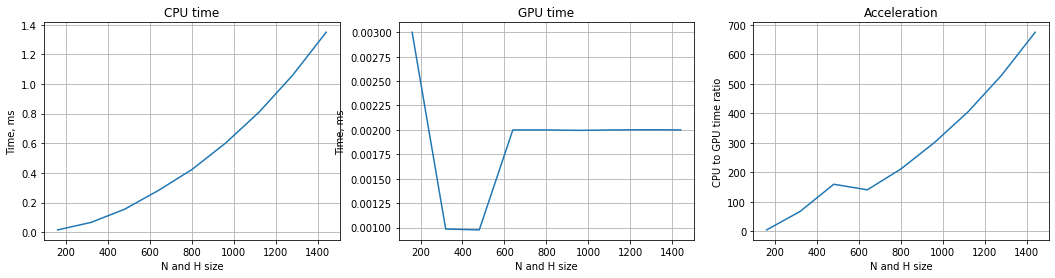

In [ ]:
test_main_algorithm_time()